## Building a Large Language Model (LLM) from Scratch

#### References
- [Andrej Karpathy's YouTube Channel](https://www.youtube.com/andrejkarpathy)
- [Build a Large Language Model (From Scratch)](https://www.manning.com/books/build-a-large-language-model-from-scratch)
- [Om-Alve/smolGPT GitHub](https://github.com/Om-Alve/smolGPT)
- Transformer Paper – [Attention Is All You Need](https://arxiv.org/abs/1706.03762)
- OpenAI GPT2 Paper - [Language Models are Unsupervised Multitask Learners](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)

### Env Setup

Install compatible pytorch according to your GPU/Cuda version.

```
pip install requests
pip install tiktoken
pip install transformers
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu116
```

## Notes

*This learning material is designed to help you study the core concepts of LLMs through simple hands-on exercises on a personal computer. It summarizes and organizes well-known educational and academic resources to make learning easier. Please note that the coding style and scope of application may differ from other implementations.*

#### About this project

When building an AI agent based on a large language model (LLM), the core component is, of course, the LLM itself. Rather than building an LLM from scratch, it's more common to take an existing open-source LLM and adapt it for your specific use case. However, recently, the barrier to entry for developing LLMs from scratch has been decreasing, so it's becoming more likely that companies will start building their own LLMs tailored to their needs.

So, When creating an LLM, the basic process is:

1. Pretraining – to teach general language abilities
2. Fine-tuning – to adapt the model for specific tasks

Additionally, by adding database (and internet) retrieval capabilities, the range and accuracy of the knowledge can be significantly improved. Just like how humans can think through problems repeatedly to reach deeper conclusions, LLMs can also be designed to internally iterate on queries to derive better answers.

In this guide, we’ll go through the pretraining process from scratch to understand the basic principles of LLMs. The training process generally follows the standard machine learning workflow:

1. Preparing training data
2. Defining a data loader
3. Defining the model
4. Training
5. Checking the results

#### 1. Preparing training data

The prepared text file is read and cleaned, then saved with the filename prefixed by `cleaned_`.
> ex) alice.txt → cleaned_alice.txt

- Kaggle Harry Potter Books – [Harry Potter Books](https://www.kaggle.com/datasets/shubhammaindola/harry-potter-books?select=02+Harry+Potter+and+the+Chamber+of+Secrets.txt)
- Kaggle Alice Book – [alice.txt](https://www.kaggle.com/datasets/leelatte/alicetxt)

In [2]:
import re

def clean_text(filename):
    with open(filename, 'r', encoding='utf-8') as file:
        book_text = file.read()

    cleaned_text = re.sub(r'\n+', ' ', book_text) # lin 줄바꿈을 빈칸으로 변경
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text) # 여러 빈칸을 하나의 빈칸으로

    print("cleaned_" + filename, len(cleaned_text), "characters") # 글자 수 출력

    with open("cleaned_" + filename, 'w', encoding='utf-8') as file:
        file.write(cleaned_text)

filenames_list = ["02 Harry Potter and the Chamber of Secrets.txt"]
# filenames_list = ["alice.txt"]

for filename in filenames_list:
    clean_text(filename)

cleaned_02 Harry Potter and the Chamber of Secrets.txt 488771 characters


## Tokenization

UTF-8 BPE(Bype Pair Encoding)

* style1. tiktoken (from OpenAI)
* style2. AutoTokenizer (from Hugging Face Transformers)

In [7]:
import tiktoken # pip install tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

text = "Harry Potter was a wizard."

tokens = tokenizer.encode(text)

print("Letter length:", len(text), "Token length: ", len(tokens))
print(tokens)
print(tokenizer.decode(tokens))
for t in tokens:
    print(f"{t}\t -> {tokenizer.decode([t])}")

Letter length: 26 Token length:  6
[18308, 14179, 373, 257, 18731, 13]
Harry Potter was a wizard.
18308	 -> Harry
14179	 ->  Potter
373	 ->  was
257	 ->  a
18731	 ->  wizard
13	 -> .


In [8]:
# from transformers import AutoTokenizer # pip install transformers

# tokenizer = AutoTokenizer.from_pretrained("LGAI-EXAONE/EXAONE-3.5-7.8B-Instruct")  # KoGPT2 사용
# # tokenizer = AutoTokenizer.from_pretrained("skt/kogpt2-base-v2")  # KoGPT2 사용

# print("Vocab size :", len(tokenizer))

# text = "대사께서는 도(道)를 얻은 모양이구려."

# tokens = tokenizer.encode(text)

# print(len(text), len(tokens))
# print(tokens)
# print(tokenizer.decode(tokens))

In [9]:
for char in text:
    token_ids = tokenizer.encode(char)     # 한 글자씩 인코딩(토큰화)
    decoded = tokenizer.decode(token_ids)  # 한 글자씩 디코딩
    print(f"{char} -> {token_ids} -> {decoded}")

H -> [39] -> H
a -> [64] -> a
r -> [81] -> r
r -> [81] -> r
y -> [88] -> y
  -> [220] ->  
P -> [47] -> P
o -> [78] -> o
t -> [83] -> t
t -> [83] -> t
e -> [68] -> e
r -> [81] -> r
  -> [220] ->  
w -> [86] -> w
a -> [64] -> a
s -> [82] -> s
  -> [220] ->  
a -> [64] -> a
  -> [220] ->  
w -> [86] -> w
i -> [72] -> i
z -> [89] -> z
a -> [64] -> a
r -> [81] -> r
d -> [67] -> d
. -> [13] -> .


#### 2. Defining a data loader

In [10]:
import torch
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, txt, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # token_ids = tokenizer.encode("<|endoftext|>" + txt, allowed_special={"<|endoftext|>"})
        token_ids = tokenizer.encode(txt)

        print("# of tokens in txt:", len(token_ids))

        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

# with open("cleaned_한글문서.txt", 'r', encoding='utf-8-sig') as file: # 선택: -sig를 붙여서 BOM 제거
with open("cleaned_02 Harry Potter and the Chamber of Secrets.txt", 'r', encoding='utf-8-sig') as file: # 선택: -sig를 붙여서 BOM 제거
    txt = file.read()

dataset = MyDataset(txt, max_length = 32, stride = 4)

train_loader = DataLoader(dataset, batch_size=128, shuffle=True, drop_last=True)

# Note: To simplify the code, we only created a train_loader and skipped test and validation sets.
#       If you're curious about the related machine learning concepts, try searching for terms like "train vs test vs validation".

# of tokens in txt: 130520


In [11]:
dataiter = iter(train_loader)

x, y = next(dataiter)

print(tokenizer.decode(x[0].tolist()))
print(tokenizer.decode(y[0].tolist()))


 slightly. Harry drew nearer to his desk and stammered, “Er — I’ll just go, shall I?” Still the wizard
. Harry drew nearer to his desk and stammered, “Er — I’ll just go, shall I?” Still the wizard ignored


#### 3. Defining the model

The model definition is a slightly modified version of the [example code](https://github.com/rasbt/LLMs-from-scratch) provided in the textbook "[Build a Large Language Model (From Scratch)](https://www.manning.com/books/build-a-large-language-model-from-scratch)"



In [5]:
# Constants for defining the model

VOCAB_SIZE = tokenizer.n_vocab # 50257 Tiktoken
#VOCAB_SIZE = len(tokenizer) # AutoTokenizer
CONTEXT_LENGTH = 128  # Shortened context length (orig: 1024)
EMB_DIM = 768  # Embedding dimension
NUM_HEADS = 12  # Number of attention heads
NUM_LAYERS = 12  # Number of layers
DROP_RATE = 0.1  # Dropout rate
QKV_BIAS = False  # Query-key-value bias

In [12]:
import torch.nn as nn

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out):
        super().__init__()
        
        assert d_out % NUM_HEADS == 0, "d_out must be divisible by n_heads"

        self.d_out = d_out
        self.head_dim = d_out // NUM_HEADS

        self.W_query = nn.Linear(d_in, d_out, bias=QKV_BIAS)
        self.W_key = nn.Linear(d_in, d_out, bias=QKV_BIAS)
        self.W_value = nn.Linear(d_in, d_out, bias=QKV_BIAS)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(DROP_RATE)
        self.register_buffer('mask', torch.triu(torch.ones(CONTEXT_LENGTH, CONTEXT_LENGTH), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x)  # (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        keys = keys.view(b, num_tokens, NUM_HEADS, self.head_dim)
        values = values.view(b, num_tokens, NUM_HEADS, self.head_dim)
        queries = queries.view(b, num_tokens, NUM_HEADS, self.head_dim)

        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        attn_scores = queries @ keys.transpose(2, 3)

        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        context_vec = (attn_weights @ values).transpose(1, 2)

        context_vec = context_vec.reshape(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)

        return context_vec

class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

class FeedForward(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(EMB_DIM, 4 * EMB_DIM),
            GELU(),
            nn.Linear(4 * EMB_DIM, EMB_DIM),
        )

    def forward(self, x):
        return self.layers(x)

class TransformerBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=EMB_DIM,
            d_out=EMB_DIM)
    
        self.ff = FeedForward()
        self.norm1 = LayerNorm(EMB_DIM)
        self.norm2 = LayerNorm(EMB_DIM)
        self.drop_shortcut = nn.Dropout(DROP_RATE)

    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        return x


class GPTModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.tok_emb = nn.Embedding(VOCAB_SIZE, EMB_DIM)
        self.pos_emb = nn.Embedding(CONTEXT_LENGTH, EMB_DIM)
        self.drop_emb = nn.Dropout(DROP_RATE)

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock() for _ in range(NUM_LAYERS)])

        self.final_norm = LayerNorm(EMB_DIM)
        self.out_head = nn.Linear(EMB_DIM, VOCAB_SIZE, bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

### 4. Training

In [13]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = "cpu"
print(device)

torch.manual_seed(123)
model = GPTModel()
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

cuda


### ⚠️Caution⚠️ This takes about **TWO HOURS**, you can also use pre-trained paramters in below

In [24]:
tokens_seen, global_step = 0, -1

losses = []

for epoch in range(100):
    model.train()  # Set model to training mode
    
    epoch_loss = 0
    for input_batch, target_batch in train_loader:
        optimizer.zero_grad() # Reset loss gradients from previous batch iteration
        input_batch, target_batch = input_batch.to(device), target_batch.to(device)

        logits = model(input_batch)
        loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
        epoch_loss += loss.item()
        loss.backward() # Calculate loss gradients
        optimizer.step() # Update model weights using loss gradients
        tokens_seen += input_batch.numel()
        global_step += 1

        if global_step % 1000 == 0:
            print(f"Tokens seen: {tokens_seen}")
        # Optional evaluation step

    avg_loss = epoch_loss / len(train_loader)
    losses.append(avg_loss)
    print(f"Epoch: {epoch + 1}, Loss: {avg_loss}")
    torch.save(model.state_dict(), "model_" + str(epoch + 1).zfill(3) + ".pth")

# Note: For convenience, all data is used for training here.  
#       In machine learning, it's common to use a portion of the data for validation.

Tokens seen: 4096


KeyboardInterrupt: 

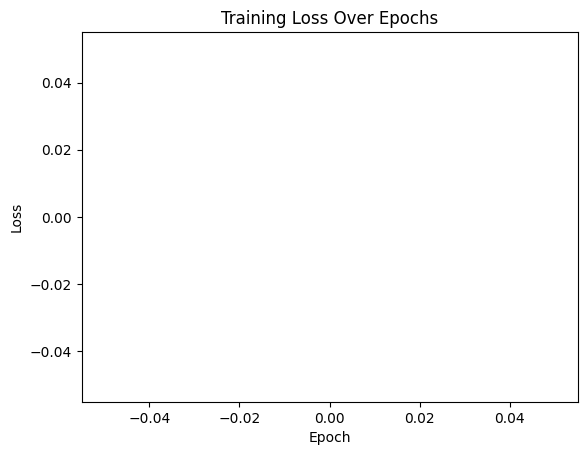

In [25]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()

# Supplement: An example showing how to plot and compare validation loss  
# https://www.geeksforgeeks.org/training-and-validation-loss-in-deep-learning/

### 5. Checking the results

In [40]:
from os import walk

cwd = os.getcwd()
cwd

'/home/kimsooyoung/Documents/Study/modern-ai-til/Projects/MyLLM'

In [46]:
# Load the saved network weights from a file
import os
import requests

file_name = "model_100.pth"
download_url = f""

if os.path.exists(file_name):
    print(f"{file_name} already exists. No action taken.")
    model.load_state_dict(torch.load("model_100.pth", map_location=device, weights_only=True))
else:
    print(f"{file_name} not found. Download from Google Drive link: https://drive.google.com/file/d/1M4SAdKsZFhZiNwsjfew7Uis4SPvmabbl/view?usp=sharing")

model_100.pth already exists. No action taken.


In [47]:
idx = tokenizer.encode("Dobby is") # List of Token IDs
idx = torch.tensor(idx).unsqueeze(0).to(device)
print(idx) # Dobby => two tokens

with torch.no_grad():
    logits = model(idx)

logits = logits[:, -1, :]

# Print the top 10 most probable words  
top_logits, top_indices = torch.topk(logits, 10) 
for p, i in zip(top_logits.squeeze(0).tolist(), top_indices.squeeze(0).tolist()):
    print(f"{p:.2f}\t {i}\t {tokenizer.decode([i])}")

# Print the most probable word  
idx_next = torch.argmax(logits, dim=-1, keepdim=True)
flat = idx_next.squeeze(0) # batch dimension sqeeze torch.Size([1])
out = tokenizer.decode(flat.tolist()) # tensor to list conversion then decode 
print(out)

tensor([[   35, 11369,   318]], device='cuda:0')
14.89	 635	  also
14.21	 973	  used
12.84	 991	  still
12.27	 1464	  always
10.92	 645	  no
10.34	 4978	  caught
10.22	 4084	  clearly
9.60	 1908	  sent
9.53	 1479	  free
9.52	 257	  a
 also


In [48]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:
            break

        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [29]:
start_context = input("Start context: ")

# idx = tokenizer.encode(start_context, allowed_special={'<|endoftext|>'})
idx = tokenizer.encode(start_context)
idx = torch.tensor(idx).unsqueeze(0)

context_size = model.pos_emb.weight.shape[0] 

for i in range(10):

    token_ids = generate(
        model=model,
        idx=idx.to(device),
        max_new_tokens=50,
        context_size= context_size,
        top_k=50,
        temperature=0.5 # Try this out! More temperature means more diversity
    )

    flat = token_ids.squeeze(0) # remove batch dimension
    out = tokenizer.decode(flat.tolist()).replace("\n", " ")

    print(i, ":", out)

Start context:  Dobby is


0 : Dobby is also, sir…Dobby is a house-elf — bound to serve one house and one family forever.…” “Do they know you think he hadn’tongue his best friends at once you’t like that
1 : Dobby is used to return to Hogwarts.” “Well, you see, Lucius,” said Dumbledore, smiling serenely, “the other than he’s in the one thing, in the one month!’s of
2 : Dobby is also, sir…” “What terrible things?” said Harry at once. “Who’s plotting them?” Dobby made Dobby made to the Dobby made its way they burst into the Dursleys
3 : Dobby is also, sir…Dobby is a house-elf — bound to serve one house and one family forever.…” “Do they know you think I don’t like that they know!’tongue, though,
4 : Dobby is also. I’ve never flown. Is it easy? Is that your own broom? Is that the best one there is?” Harry didn’t know how he didn” Harry didn’t know how he didn�
5 : Dobby is also, sir…” “What’re you doin’ here?” said Hagrid furiously. “Get outta you, it?’s in the way,’Course,’s in
6 : Dobby is still treated like the 

#### Supplement

- The LLM introduced here is an autoregressive LLM, which generates text one token at a time. (Also called as "self-regressive")
- Recently, **Diffusion** LLMs have also started to emerge. Unlike autoregressive models, they generate the entire output all at once. (See [Reference 1](https://x.com/karpathy/status/1894923254864978091), [Reference 2](https://x.com/omarsar0/status/1891568386494300252))